In [ ]:
#TODO: Pick up cosine similarity, name analysis and TFIDF.
# Also, I'm now realizing I used KDEs in a lot of places that weren't ideal. Update those.
# 1.5 hours down.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from difflib import get_close_matches
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

In [2]:
# Do some "scraping" because for some reason it's impossible to download a google doc???
google_doc_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRulk_F0RfOaVih3qG4HWaruR6Q0VxiiAtfdYKgPUOLsC7FGPafOV-yp0g-aANfgR5Pg2RAsVwXIWHj/pubhtml#'
response = requests.get(google_doc_path)
soup = BeautifulSoup(response.text, 'html')
ratings_table = soup.find_all('table')[1] # 2nd sheet

# the final DF
df = pd.read_html(ratings_table.prettify(), header = 1, flavor='bs4')[0] # returned as list for some dumb pandas reason

In [3]:
# Start off by cleaning up some columns
dumb_cols = [col for col in df if df[col].nunique() == 1] + ['1']  # Index col (1) got thrown into the data too when scraping
df.drop(dumb_cols, axis = 1, inplace = True)

# use snek_case because we live in a fucking society.
df.columns = ['rating', 'review', 'display_name', 'display_image_url', 'is_verified', 'is_super_reviewer',
              'has_spoilers', 'has_profanity', 'create_date', 'update_date', 'user_id', 'user_realm',
              'user_display_name', 'user_acocuntlink']

# infer dates
df = df.infer_objects()
df['create_date'] = pd.to_datetime(df['create_date'])
df['update_date'] = pd.to_datetime(df['update_date'])

# Why the duplicate username column?
assert not df[df['display_name'] != df['user_display_name']].any().any()
df.drop('user_display_name', axis = 1, inplace = True)

# lowercase for consistency later
df['display_name'] = df['display_name'].str.lower()

In [4]:
df.head()

,rating,review,display_name,display_image_url,is_verified,is_super_reviewer,has_spoilers,has_profanity,create_date,update_date,user_id,user_realm,user_acocuntlink
0,0.5,"All rushed choppy nonsense, incoherent story a...",sam,NaN,1,0,0,0,2019-12-26,2019-12-26,F8B6EADA-C1F0-4146-B312-D7752A64ED2C,Fandango,NaN
1,0.5,A pointless mess of a movie. What a waste!,z_fam l,NaN,1,0,0,0,2019-12-26,2019-12-26,5606cc3f-21d1-4306-9eba-096d057d5061,Fandango,NaN
2,0.5,A complete lack of imagination drives this mov...,a a,NaN,1,0,0,0,2019-12-26,2019-12-26,978397911,RT,/user/id/978397911
3,0.5,Awful. Ignored the mythology set up in all pre...,joel r,NaN,1,0,0,1,2019-12-20,2019-12-20,83e8986d-49db-4cde-8a11-95e9a2595d9e,Fandango,NaN
4,0.5,"bad, all kinds of garbage.",mike,NaN,1,0,0,0,2019-12-27,2019-12-27,24C2A16A-BDBE-43C2-AD18-F2CD6F98D182,Fandango,NaN


# General Stats and Visualizations

plain old review count histogram

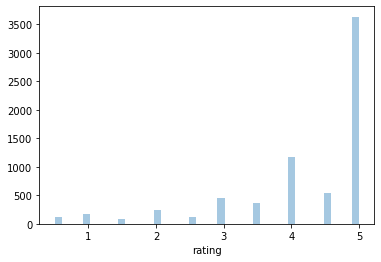

In [5]:
sns.distplot(df['rating'], kde = False)

One thing I was actually curuous about myself was the number of reviews of a given type over time. If Disney was smart, they would definetly "trickle" their "fake" 5-star reviews in over time. Not all at once. Unfortunately the only granularity we have is up to the day for about a week and half.

,5.0,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5
create_date,,,,,,,,,,
20,54.235638,8.763389,16.066212,4.576436,5.744888,1.460565,3.310613,1.265823,2.921130,1.655307
21,55.488419,8.559919,17.220544,4.632427,4.934542,1.208459,2.819738,0.704935,2.316213,2.114804
22,53.539157,7.003012,16.189759,5.798193,7.304217,2.183735,3.313253,1.054217,2.033133,1.581325
23,49.885057,7.586207,17.011494,5.747126,7.586207,1.839080,4.367816,0.689655,2.758621,2.528736
24,57.608696,6.521739,12.681159,2.173913,7.971014,2.536232,5.072464,1.811594,2.173913,1.449275
25,46.099291,9.929078,15.602837,4.964539,7.092199,4.964539,4.255319,2.127660,1.418440,3.546099
26,50.757576,8.549784,16.341991,4.329004,7.900433,1.623377,4.761905,1.082251,2.272727,2.380952
27,48.210736,7.753479,19.880716,6.660040,7.057654,1.292247,3.578529,1.192843,2.385686,1.988072
28,53.197279,6.938776,18.095238,6.530612,5.578231,2.176871,3.265306,1.088435,2.312925,0.816327


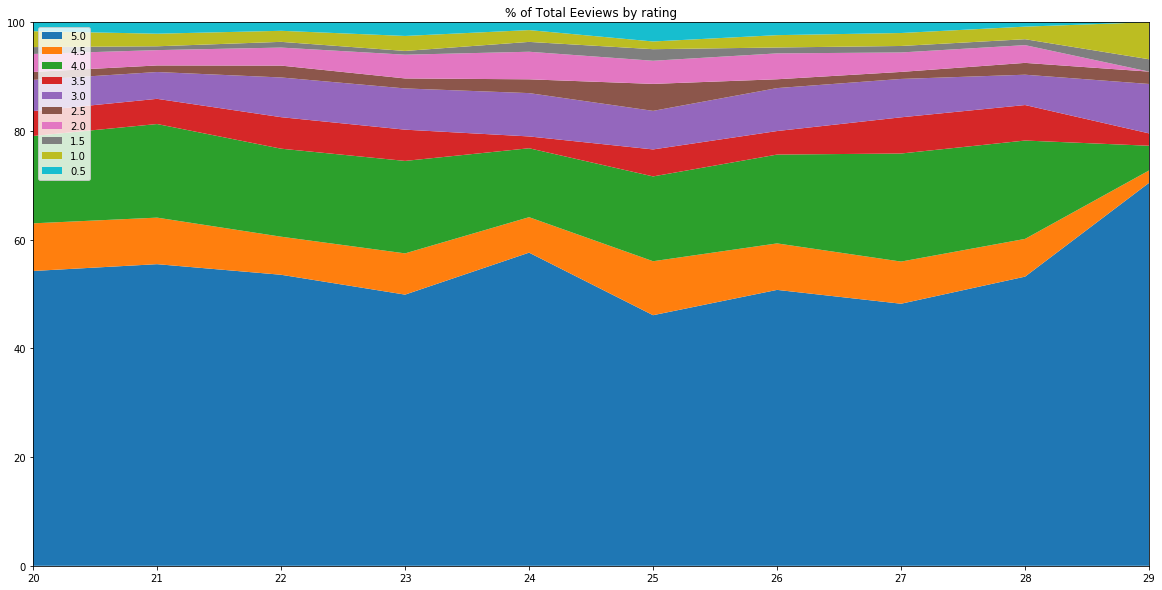

In [7]:
daily_pct_score = df.groupby(df['create_date'].dt.day)['rating'].apply(lambda grp: 
    100 * grp.value_counts() / grp.size).unstack().T[::-1].T.fillna(0) # Transpose and reverse just to not look "upsidedown"

plt.figure(figsize=(20,10))

plt.stackplot(daily_pct_score.index, *[daily_pct_score[col] for col in daily_pct_score], 
              labels=daily_pct_score.columns)
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('% of Total Eeviews by Rating')
display(daily_pct_score)
plt.show()

Nothing jumps out at me above other than the spike from 50% reviews being 5 star to over 70%. Perhaps there's a factor in play on the 29th? Perhaps its Disney? Perhaps it's chance. All I know is that I don't reall give a shit and should've never gotten myself into this.

Standard Deviations:
{0.5: 29.16, 1.0: 44.09, 1.5: 69.4, 2.0: 29.85, 2.5: 66.33, 3.0: 31.48, 3.5: 32.56, 4.0: 23.41, 4.5: 24.35, 5.0: 17.16}


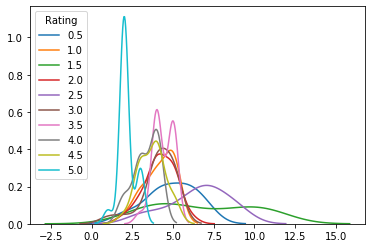

In [10]:
for key, grp in df.groupby('rating'):
    g = sns.kdeplot(grp['review'].apply(lambda x: len(x.split())).sort_values()[:20], label = key)
      
# As you can see, the ratings for 5 stars have a MUCH lower word count. Disgruntled, lower reviews are much wordier
plt.legend(title='Rating', loc='upper left', labels=df.groupby('rating').groups)

# This is verfified by the STD of each group as well. 5 star reviews have a STD nearly 4x lower than 1.5 star reviews.
print('Standard Deviations:')
print({key: grp['review'].apply(lambda x: len(x.split())).std().round(2)
       for key, grp in df[['rating', 'review']].groupby('rating')})

plt.show(g)

# Text Analyses

## Saga count

Just a quick check of the count for the word "saga" in each score category

Text(0, 0.5, 'Average number of "saga" per review')

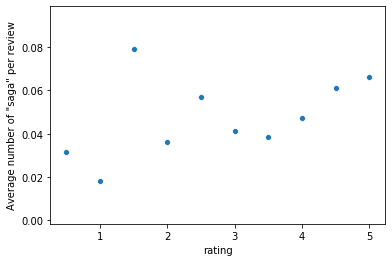

In [12]:
# Inefficient af, i know. 
saga_counts = df.groupby('rating')['review'].agg(lambda s: s.apply(lambda x: x.lower().split().count('saga')).mean()).sort_index()

sns.scatterplot(x = saga_counts.index, y = saga_counts)
plt.ylabel('Average number of "saga" per review')

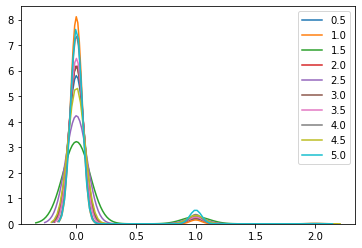

In [13]:
for key, grp in df.groupby('rating'):
    g = sns.kdeplot(grp['review'].apply(lambda x: x.lower().split().count('saga')), label = key)

## TFIDF analysis

Another thing we can do at least is look at the TFIDF of reviews. OP of the video suspected that Disney had concocted a couple of go-to statements with interchanged words here and there. A TFIDF analysis should reveal those reviews as having a very low average TFDIF. I also wanna look at how the word "saga" fares.

rating
0.5    0.000665
1.0    0.000644
1.5    0.000694
2.0    0.000650
2.5    0.000676
3.0    0.000628
3.5    0.000668
4.0    0.000600
4.5    0.000595
5.0    0.000522
Name: mean_tfidf, dtype: float64
Spearman correlation between score and average TFIDF of the sentence: -0.2214394687109041


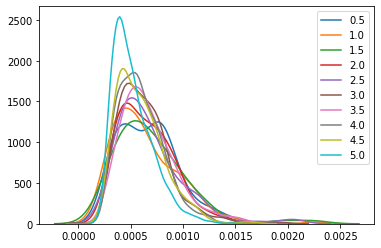

In [15]:
vec = TfidfVectorizer()

tfidfs = vec.fit_transform(df['review'])
df['mean_tfidf'] = tfidfs.mean(axis = 1)
df['max_tfidf'] = tfidfs.max(axis = 1).todense()

print(df.groupby('rating')['mean_tfidf'].mean())
corr = df[['rating', 'mean_tfidf']].corr(method = 'spearman').iloc[0, 1]
print(f"Spearman correlation between score and average TFIDF of the sentence: {corr}")

for key, grp in df.groupby('rating'):
    sns.kdeplot(grp['mean_tfidf'], label = key)
    

Interesting... It does look like higher scoring reviews seem to have a lower average TFIDF. In addition there is a negative correlation betweeen score and average TFIDF, which would suggegst that higher scoring reviews use less unique language. However, not much can be said with a correlation of ~20%. 

In [17]:
similarities = cosine_similarity(tfidfs, tfidfs)
df['cosine_similarity'] = similarities.mean(axis = 1)

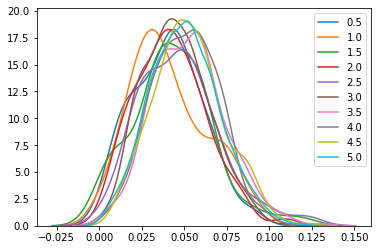

In [18]:
for key, grp in df.groupby('rating'):
    sns.kdeplot(grp['cosine_similarity'], label = key)

While we have out matrix in TFIDF form, we might as well compute a cosine similarity matrix

If Disney really is injecting the word "saga" into their cookie-cutter reviews, then we would definetly expect a lower TFIDF in the distribution of reviews that include the word "saga" as opposed to the ones that don't.

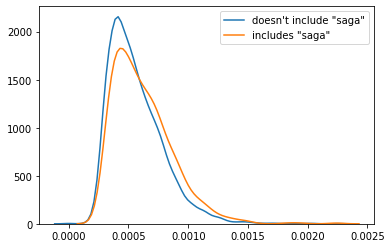

In [390]:
for key, grp in df.groupby(lambda ind: 'includes "saga"' if 'saga' in df.loc[ind, 'review'] else 'doesn\'t include "saga"'):
    sns.kdeplot(grp['mean_tfidf'], label = key)

In [192]:
df.groupby('score')['mean_tfidf'].describe()

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
0.5,127.0,0.000665,0.000280,0.000220,0.000439,0.000674,0.000826,0.001526
1.0,165.0,0.000644,0.000314,0.000210,0.000411,0.000579,0.000845,0.002269
1.5,76.0,0.000694,0.000351,0.000215,0.000460,0.000637,0.000867,0.002239
2.0,249.0,0.000650,0.000266,0.000167,0.000445,0.000618,0.000822,0.001770
2.5,123.0,0.000676,0.000320,0.000265,0.000448,0.000610,0.000783,0.002043
3.0,459.0,0.000628,0.000246,0.000000,0.000452,0.000594,0.000763,0.001978
3.5,364.0,0.000668,0.000260,0.000246,0.000478,0.000618,0.000807,0.001640
4.0,1168.0,0.000600,0.000219,0.000209,0.000433,0.000567,0.000731,0.001836
4.5,542.0,0.000595,0.000228,0.000217,0.000417,0.000558,0.000727,0.001695


## Name Analysis

In [119]:
# Grab a table of top common male/female US names. (I don't care about the reliability of the site tbh...)
male_name_url = 'https://names.mongabay.com/male_names_alpha.htm'
response = requests.get(male_name_url)
soup = BeautifulSoup(response.text, 'html')
male_name_table = soup.find_all('table')[0]
male_names_df = pd.read_html(male_name_table.prettify(), flavor='bs4')[0]
female_names_df['gender'] = 'Male'

female_name_url = 'https://names.mongabay.com/female_names_alpha.htm'
response = requests.get(female_name_url)
soup = BeautifulSoup(response.text, 'html')
female_name_table = soup.find_all('table')[0]
female_names_df = pd.read_html(female_name_table.prettify(), flavor='bs4')[0]
female_names_df['gender'] = 'Female'


# combine tables
names_df = male_names_df.append(female_names_df)
names_df.columns = ['frequency', 'number', 'name', 'rank', 'gender']  # WE LIVE IN A FUCKING SOCIETY
names_df.sort_values('name', inplace = True)
names_df['frequency'] = names_df['frequency'] / 2  # Frequency was percent of gender so I'm making the assumption here
# that male/females are in 1:1 ratio with eachother. In reality I think it's 48/52 or something but close enough.

names_df = names_df[names_df['name'].notna()] # Whyy?
names_df['name'] = names_df['name'].str.lower()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [123]:
get_close_matches('ayron', names_df['name'].values)

['aron', 'tyron', 'myron']

In [112]:
len(names_df[names_df['name'].isna()])

0

In [89]:
import difflib

In [78]:
male_names_df['%  Frequency'].sum()

90.05199999999999

In [59]:
# WE LIVE IN A FUCKING SOCIETY
names_df.columns = ['name', 'frequency', 'number', 'rank']

1219

In [60]:
names_df = male_names_df.append(female_names_df)

5494